In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os

def calculate_distance_from_point_to_station(row, given_point_coord):
    station_coord = (row['LATITUDE:'], row['LONGITUDE:'])
    # given_point_coord = (-15.789343, -47.925756)
    return geodesic(station_coord, given_point_coord).kilometers

df_all_stations = pd.read_csv("../data/all_stations.csv", decimal=",", sep=";")

# given_point_coord = (-16.012222, -47.557417)
# df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, given_point_coord), axis=1) 

# df_nearest_stations = df_all_stations[df_all_stations["Distancia"] < 50]

# df_point_stations = df_all_stations[df_all_stations["Distancia"] < 1]

# Estaçoes do DF
codes_of_stations_to_analyze = ["A001", "A042", "A045", "A046", "A047"]

stations_data = []

# stations_files_to_read = set()

for code in codes_of_stations_to_analyze:
    station_info = df_all_stations[df_all_stations["CODIGO (WMO):"] == code]

    latitude = station_info["LATITUDE:"].iloc[0]
    longitude = station_info["LONGITUDE:"].iloc[0]

    station_coord = (latitude, longitude)

    df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, station_coord), axis=1) 
    df_nearest_stations = df_all_stations[(df_all_stations["Distancia"] != 0) & (df_all_stations["Distancia"] < 50)]

    station_data = { 
        "code": code,
        "station_info": station_info,
        "nearest_stations_info": df_nearest_stations,
    }

    # df_nearest_stations["Arquivo"].apply(lambda x: stations_files_to_read.add(x))
    # stations_files_to_read.add(station_info["Arquivo"].iloc[0])
    stations_data.append(station_data)

print(stations_data)
# print(stations_files_to_read)

[{'code': 'A001', 'station_info':     REGI?O: UF:  ESTAC?O: CODIGO (WMO):   LATITUDE:  LONGITUDE: ALTITUDE:  \
442      CO  DF  BRASILIA          A001  -15.789343  -47.925756   1160.96   

                                               Arquivo  
442  INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2...  , 'nearest_stations_info':     REGI?O: UF:            ESTAC?O: CODIGO (WMO):     LATITUDE:    LONGITUDE:  \
2        CO  DF  PARANOA (COOPA-DF)          A047    -16.012222    -47.557417   
141      CO  DF          BRAZLANDIA          A042  -15.59972221   -48.1311111   
233      CO  DF     AGUAS EMENDADAS          A045    -15.596491    -47.625801   
239      CO  DF   GAMA (PONTE ALTA)          A046  -15.93527777  -48.13749999   

    ALTITUDE:                                            Arquivo  Distancia  
2      1043.0  INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2019...  46.520207  
141    1143.0  INMET_CO_DF_A042_BRAZLANDIA_01-01-2019_A_31-12...  30.411300  
233   1030.36  INMET_CO_DF_A045

In [6]:
# yeardirectoryfilename = []
# df_nearest_stations_weather_data = []

# stations_dataframes = {
    
# }

def read_station_data(filename, start_year, end_year):
    station_data = []

    for year in range(start_year, end_year + 1):
        file = f'../data/cleaned_data/{year}_cleaned/{filename.replace("2019", str(year))}'
        df_weather_data = pd.read_csv(file, decimal=".", sep=";")
        station_data.append(df_weather_data)

    return pd.concat(station_data, ignore_index= True)

for station in stations_data:
    station_info = station["station_info"]
    station_file_name = station_info["Arquivo"].iloc[0]

    station["station_data"] = read_station_data(station_file_name, 2019, 2024)

    nearest_stations_data = []
    for index, nearest_station in station["nearest_stations_info"].iterrows():
        nearest_station_file_name = nearest_station["Arquivo"]
        nearest_station_data = read_station_data(nearest_station_file_name, 2019, 2024)

        nearest_stations_data.append(nearest_station_data)

    nearest_stations_data_compilation = pd.concat(nearest_stations_data, ignore_index= True)

    station["nearest_stations_data"] = nearest_stations_data_compilation

/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, 

              station  rmse_raw  rmse_bias  smape_raw  smape_bias        ME  \
0            BRASILIA  1.583346   1.529634   5.274785    5.113966  0.306350   
1     AGUAS EMENDADAS  1.722107   1.671085   6.108539    5.861181  0.315689   
2          BRAZLANDIA  1.851952   1.728483   6.523944    6.023937  0.306671   
3   GAMA (PONTE ALTA)  1.983150   1.814986   7.081702    6.313857  0.302330   
4  PARANOA (COOPA-DF)  1.998926   1.873065   6.832760    6.340011  0.306571   

   n_test cutoff_date  
0     439  2023-10-19  
1     439  2023-10-19  
2     439  2023-10-19  
3     439  2023-10-19  
4     439  2023-10-19  


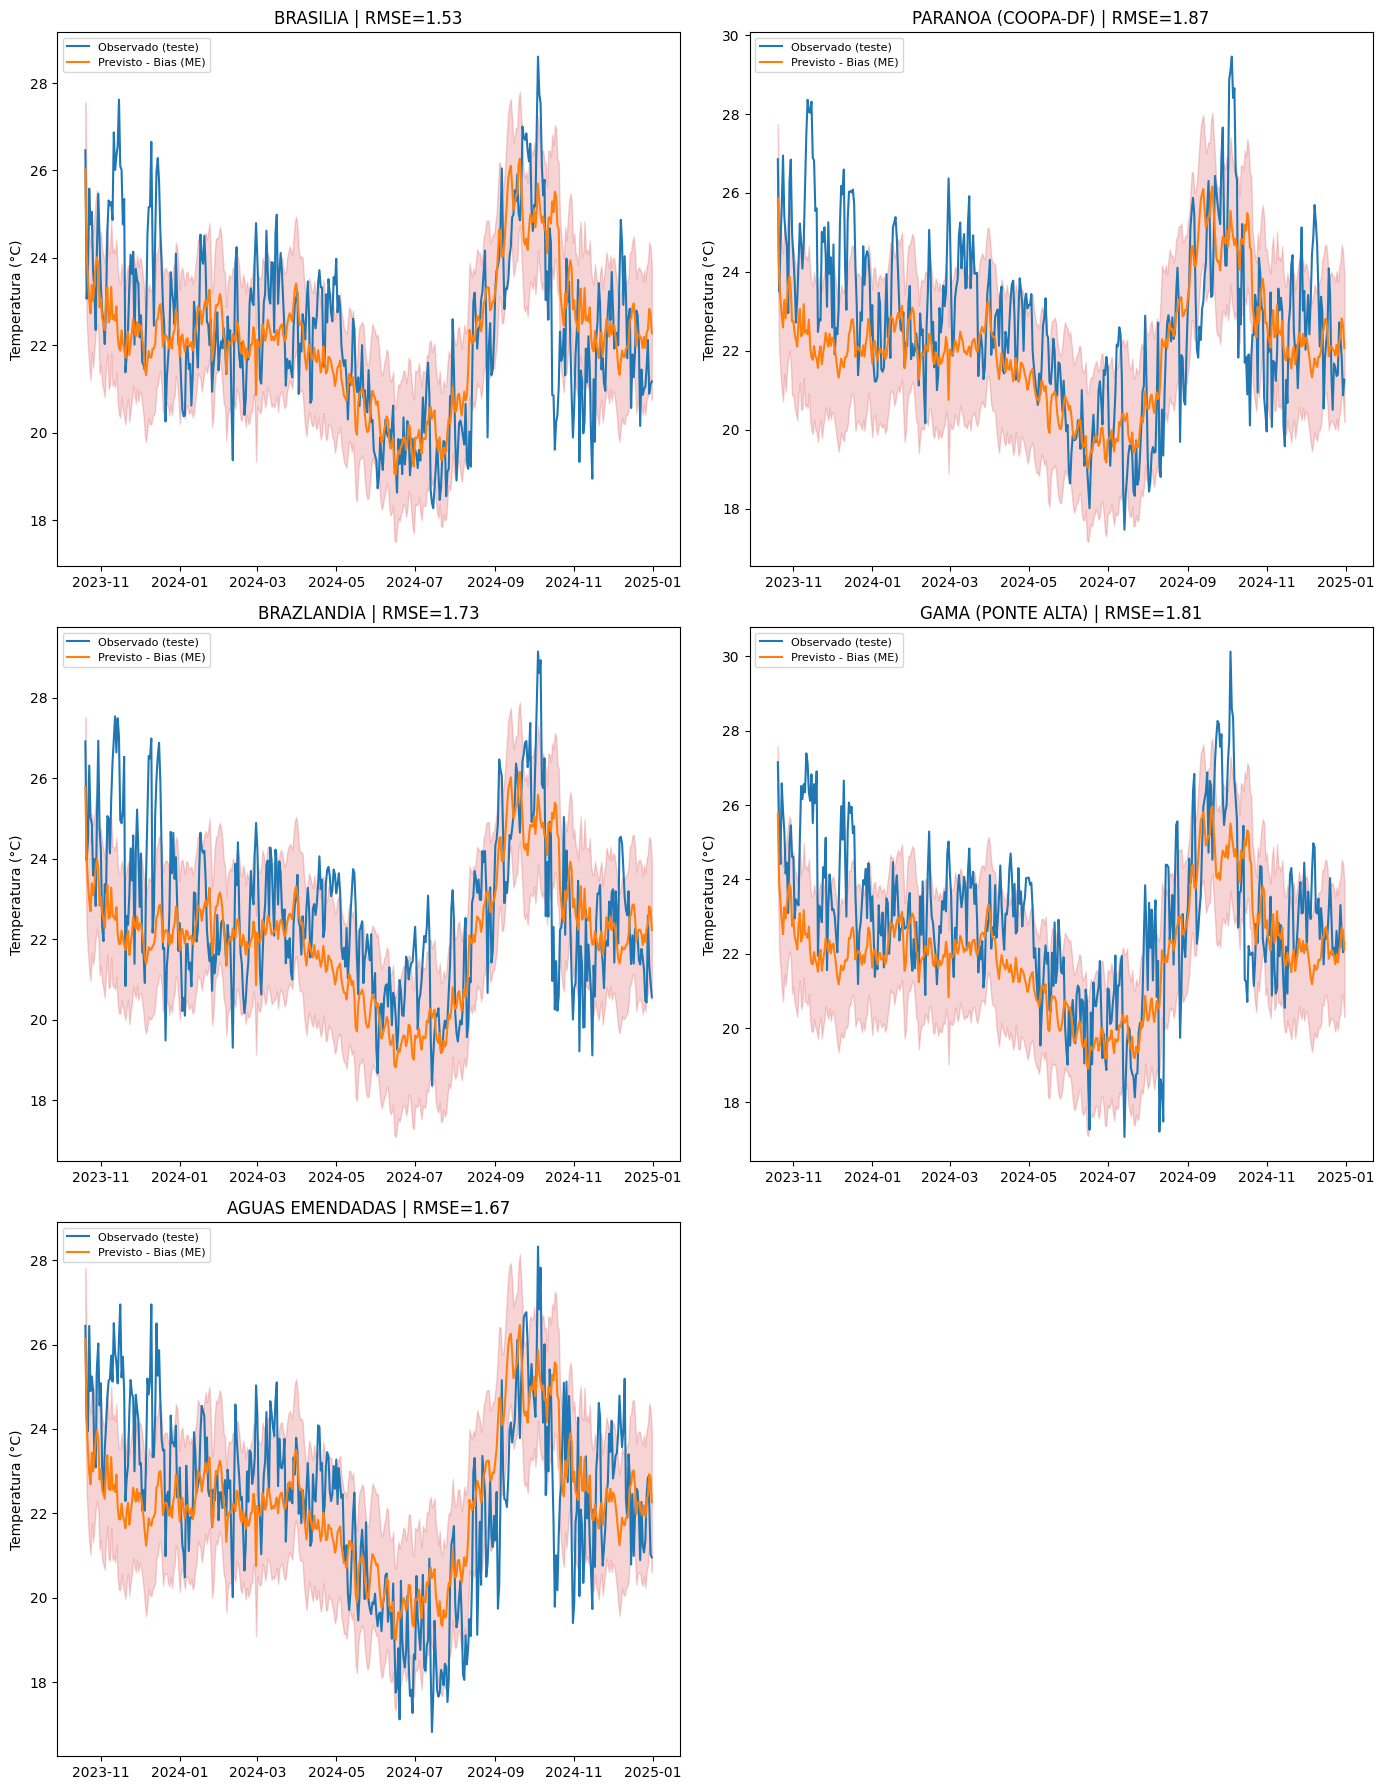

In [9]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns


# df_nearest_stations_weather_data = []

# for filename in df_nearest_stations['Arquivo']: 
#     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
#     df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

def clean_data(dataframe):
    df_cleaned = dataframe.drop(columns=['Hora UTC'])
    df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

    df_sorted = df_cleaned.sort_values(by='Data', ascending=True)
    df_sorted.set_index('Data', inplace=True)
    df_avarage_temperature_by_day = df_sorted.resample("D").mean()
    df_not_null_values_day = df_avarage_temperature_by_day.ffill()

    return df_not_null_values_day

def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def get_forecast_test_graph(df_test, forecast, forecast_parameter, ax):
    import numpy as np
    from scipy import stats
    from sklearn.metrics import mean_squared_error
    import seaborn as sns

    values = np.vstack([df_test[forecast_parameter], forecast])
    kernel = stats.gaussian_kde(values)(values)

    # Scatterplot com seaborn no eixo fornecido
    sns.scatterplot(
        x=df_test[forecast_parameter],
        y=forecast,
        hue=kernel,
        palette="viridis",
        ax=ax,
        legend=False
    )

    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5

    # Linha de referência x=y
    ax.plot(df_test[forecast_parameter], df_test[forecast_parameter], color='black', linewidth=1.0)

    # Texto RMSE
    ax.text(0.95, 0.05, f'RMSE: {rmse:.2f} °C', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

    ax.set_ylabel('Temperatura Observada (°C)')
    ax.set_xlabel('Temperatura Prevista (°C)')

def get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name):
    n_graphs = len(df_tests)
    n_cols = 2
    n_rows = (n_graphs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i in range(n_graphs):
        get_forecast_test_graph(df_tests[i], forecasts[i], forecast_parameter, ax=axes[i])
        axes[i].set_title(f'Estação {stations_name[i]}')

    # Remove os eixos extras se n_graphs for ímpar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def arima_forecast_with_fourier_terms(df_training, df_test, forecast_parameter, title):
    n = len(df_training[forecast_parameter])  # Number of data points
    t = np.arange(n)
    seasonality = 365

    num_fourier_terms = 4
    fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

    # Fit the ARIMA model using arima with Fourier terms as exogenous variables
    model = ARIMA(df_training[forecast_parameter],exog=fourier_terms[:n], order=(3,0,1))
    model_fit = model.fit()

    # Forecast future values with the fitted model
    forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test)), seasonality, num_fourier_terms)

    # Get the forecast for the future steps with exogenous variables
    forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

    # Fazer previsões
    forecast = model_fit.forecast(steps=len(df_test), exog=forecast_df)

    # Visualização das previsões
    plt.figure(figsize=(12,6))
    plt.plot(df_test.index, df_test[forecast_parameter], label='Teste')
    plt.plot(df_test.index, forecast, label='Previsão')
    plt.ylabel('Temperatura')
    plt.legend(loc='upper left')

    # Cálculo erro quadrático
    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5
    smape_value = smape(df_test[forecast_parameter], forecast)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'sMAPE: {smape_value}')
    plt.fill_between(df_test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

    plt.title(title)

    plt.show()

    return forecast


def arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, title):
    n = len(df_training[forecast_parameter])  # Number of data points
    t = np.arange(n)
    seasonality = 365

    num_fourier_terms = 4
    fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

    exog_vars = ["RADIACAO GLOBAL (KJ/m²)", "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)", "UMIDADE RELATIVA DO AR, HORARIA (%)"]

    X_train_extra = df_training[exog_vars].values
    X_test_extra = df_test_without_the_station[exog_vars].values

    X_train_final = np.hstack([X_train_extra, fourier_terms[:n]])

    # Fit the ARIMA model using arima with Fourier terms as exogenous variables
    model = ARIMA(df_training[forecast_parameter],exog=X_train_final, order=(3,0,1))
    model_fit = model.fit()

    print(model_fit.summary())

    # Forecast future values with the fitted model
    forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test)), seasonality, num_fourier_terms)

    X_test_final = np.hstack([X_test_extra, forecast_exog])

    # Get the forecast for the future steps with exogenous variables
    # forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

    # Fazer previsões
    forecast = model_fit.forecast(steps=len(df_test), exog=X_test_final)

    # Visualização das previsões
    plt.figure(figsize=(12,6))
    plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
    plt.plot(df_test.index, df_test[forecast_parameter], label='Teste')
    plt.plot(df_test.index, forecast, label='Previsão')
    plt.ylabel('Temperatura')
    plt.legend(loc='upper left')

    # Cálculo erro quadrático
    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5
    smape_value = smape(df_test[forecast_parameter], forecast)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'sMAPE: {smape_value}')
    plt.fill_between(df_test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

    plt.title(title)

    plt.show()

    return forecast

# forecasts = []
# df_tests = []
# stations_name = []
# forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
# for station in stations_data:
#     cleaned_station_data = clean_data(station["station_data"])
#     cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


#     # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
#     training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
#     df_training = cleaned_nearest_stations_data[:training_data_length]
#     df_test = cleaned_station_data[training_data_length:]

#     station_name = station["station_info"]["ESTAC?O:"].iloc[0]
#     forecast = arima_forecast_with_fourier_terms(df_training, df_test, forecast_parameter, f'Previsão da Temperatura na Estação - {station_name}')
#     # df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

#     forecasts.append(forecast)
#     df_tests.append(df_test)
#     stations_name.append(station_name)

# get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name)


# forecasts = []
# df_tests = []
# stations_name = []
# for station in stations_data:
#     cleaned_station_data = clean_data(station["station_data"])
#     cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


#     # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
#     training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
#     df_training = cleaned_nearest_stations_data[:training_data_length]
#     df_test_without_the_station = cleaned_nearest_stations_data[training_data_length:]
#     df_test = cleaned_station_data[training_data_length:]

#     station_name = station["station_info"]["ESTAC?O:"].iloc[0]
#     forecast = arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, f'Previsão da Temperatura na Estação - {station_name}')
#     # df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

#     forecasts.append(forecast)
#     df_tests.append(df_test)
#     stations_name.append(station_name)


# get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name)
import numpy as np
import pandas as pd
from typing import List, Optional, Tuple, Dict
from dataclasses import dataclass
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

@dataclass
class StationResult:
    station: str
    rmse_raw: float
    rmse_bias: Optional[float]
    smape_raw: float
    smape_bias: Optional[float]
    y_true: pd.Series
    y_pred_raw: pd.Series
    y_pred_bias: Optional[pd.Series]
    cutoff: pd.Timestamp


def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return 100*np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2*np.pi*i*t/period))
        terms.append(np.cos(2*np.pi*i*t/period))
    return np.column_stack(terms)

def build_climatology_exog(df_train_daily: pd.DataFrame, idx_test: pd.DatetimeIndex, exog_vars: List[str]) -> np.ndarray:
    prof = df_train_daily.copy()
    prof["__mm__"] = prof.index.month
    prof["__dd__"] = prof.index.day
    profile_mmdd = prof.groupby(["__mm__", "__dd__"])[exog_vars].mean()

    test_mmdd = pd.MultiIndex.from_arrays(
        [pd.Index(idx_test.month, name="__mm__"), pd.Index(idx_test.day, name="__dd__")],
        names=["__mm__", "__dd__"]
    )
    X_test = profile_mmdd.reindex(test_mmdd)

    miss = X_test.isna().any(axis=1)
    if miss.any():
        feb28 = profile_mmdd.reindex(pd.MultiIndex.from_arrays([pd.Index([2], name="__mm__"), pd.Index([28], name="__dd__")]))
        mar01 = profile_mmdd.reindex(pd.MultiIndex.from_arrays([pd.Index([3], name="__mm__"), pd.Index([1], name="__dd__")]))
        if not feb28.isna().any().any() and not mar01.isna().any().any():
            X_test.loc[miss, exog_vars] = (feb28.values + mar01.values)/2.0

    if X_test.isna().any().any():
        prof_doy = df_train_daily.copy()
        prof_doy["__doy__"] = prof_doy.index.dayofyear
        profile_doy = prof_doy.groupby("__doy__")[exog_vars].mean()
        test_doy = ((idx_test.dayofyear - 1) % 365) + 1
        X_fallback = profile_doy.reindex(test_doy).to_numpy()
        X_test = X_test.fillna(pd.DataFrame(X_fallback, index=X_test.index, columns=exog_vars))

    if X_test.isna().any().any():
        for c in exog_vars:
            X_test[c].fillna(X_test[c].mean(), inplace=True)

    return X_test.to_numpy()

def debias_mean_error(model_fit, df_train_daily, target_col, X_train, forecast_vals, calib_days=60):
    """Corrige por viés médio (ME) usando k últimos dias do TREINO."""
    n_train = len(df_train_daily)
    k = max(1, min(calib_days, n_train))
    start_idx = df_train_daily.index[n_train - k]

    pred_cal = model_fit.get_prediction(
        start=start_idx,
        end=df_train_daily.index[-1],
        exog=X_train[n_train - k:]
    ).predicted_mean

    y_cal = df_train_daily[target_col].iloc[-k:]
    ME = (y_cal - pred_cal).mean()
    forecast_bias_fixed = forecast_vals + ME
    return ME, forecast_bias_fixed

def loso_datecut_arimax(
    df: pd.DataFrame,
    station_col: str,
    target: str,
    exog_vars: Optional[List[str]] = None,   # None → só Fourier
    order: Tuple[int,int,int] = (3,0,1),
    trend: str = 'c',
    seasonality: int = 365,
    num_fourier_terms: int = 4,
    cutoff_ratio: float = 0.8,               # 80% das DATAS do pool
    calibrate: bool = True,                  # ativa debias (ME)
    calib_days: int = 60,
    verbose: bool = True,
) -> Tuple[pd.DataFrame, Dict[str, StationResult]]:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("O índice do df precisa ser DatetimeIndex.")

    need = [station_col, target] + (exog_vars or [])
    miss = [c for c in need if c not in df.columns]
    if miss: raise ValueError(f"Colunas ausentes no df: {miss}")

    df = df.sort_index().copy()
    stations = df[station_col].unique().tolist()
    rows, results = [], {}

    for st in stations:
        df_station = df[df[station_col] == st].copy()
        pool = df[df[station_col] != st].copy()
        if pool.empty or df_station.empty:
            if verbose: print(f"[SKIP] {st}: pool ou estação vazio."); continue

        uniq_dates = pd.DatetimeIndex(pool.index.unique().sort_values())
        if len(uniq_dates) < 10:
            if verbose: print(f"[SKIP] {st}: poucas datas no pool."); continue
        cutoff_date = uniq_dates[max(1, int(len(uniq_dates)*cutoff_ratio)) - 1]

        pool_daily = pool.groupby(pool.index.normalize()).mean(numeric_only=True)
        df_train_daily = pool_daily.loc[pool_daily.index <= cutoff_date]
        df_test_station = df_station.loc[df_station.index > cutoff_date]
        if df_train_daily.empty or df_test_station.empty:
            if verbose: print(f"[SKIP] {st}: sem dados após {cutoff_date.date()}."); continue

        # Fourier (continuação)
        n = len(df_train_daily[target])
        fourier_train = create_fourier_terms(np.arange(n), seasonality, num_fourier_terms)
        fourier_test  = create_fourier_terms(np.arange(n, n+len(df_test_station)), seasonality, num_fourier_terms)

        # Exógenas
        if exog_vars:
            X_train_extra = df_train_daily[exog_vars].values
            X_test_extra  = build_climatology_exog(df_train_daily, df_test_station.index, exog_vars)
        else:
            X_train_extra = np.zeros((len(df_train_daily), 0))
            X_test_extra  = np.zeros((len(df_test_station), 0))

        X_train = np.hstack([X_train_extra, fourier_train])
        X_test  = np.hstack([X_test_extra,  fourier_test])

        y_train = df_train_daily[target].astype(float)
        y_test  = df_test_station[target].astype(float)

        fit = ARIMA(y_train, exog=X_train, order=order, trend=trend).fit()
        y_pred_raw = fit.forecast(steps=len(df_test_station), exog=X_test)

        # ---- Debias (ME) opcional ----
        if calibrate:
            ME, bias_fixed = debias_mean_error(fit, df_train_daily, target, X_train, y_pred_raw, calib_days=calib_days)
            y_pred_bias = pd.Series(bias_fixed, index=y_test.index, name="y_pred_bias")
            rmse_bias = mean_squared_error(y_test, y_pred_bias)**0.5
            sm_bias = smape(y_test, y_pred_bias)
        else:
            ME = 0.0
            y_pred_bias = None
            rmse_bias = None
            sm_bias = None

        # Métricas raw
        rmse_raw = mean_squared_error(y_test, y_pred_raw)**0.5
        sm_raw   = smape(y_test, y_pred_raw)

        rows.append({
            "station": st,
            "rmse_raw": rmse_raw,
            "rmse_bias": rmse_bias,
            "smape_raw": sm_raw,
            "smape_bias": sm_bias,
            "ME": ME,
            "n_test": len(y_test),
            "cutoff_date": cutoff_date
        })

        results[st] = StationResult(
            station=st,
            rmse_raw=rmse_raw,
            rmse_bias=rmse_bias,
            smape_raw=sm_raw,
            smape_bias=sm_bias,
            y_true=pd.Series(y_test.values, index=y_test.index, name="y_true"),
            y_pred_raw=pd.Series(np.asarray(y_pred_raw), index=y_test.index, name="y_pred_raw"),
            y_pred_bias=(pd.Series(bias_fixed, index=y_test.index, name="y_pred_bias") if calibrate else None),
            cutoff=cutoff_date
        )

    metrics = pd.DataFrame(rows)
    if metrics.empty:
        if verbose: print("[WARN] Nenhuma estação produziu métricas."); 
        return metrics, results

    return metrics.sort_values("rmse_raw").reset_index(drop=True), results

import matplotlib.pyplot as plt
import numpy as np

def plot_loso_test_only_bias(per_station: Dict[str, StationResult],
                             n_cols: int = 2, figsize: Tuple[int,int] = (14,6),
                             show_band: bool = True, fallback_raw: bool = True):
    import matplotlib.pyplot as plt, numpy as np
    n_stations = len(per_station)
    if n_stations == 0:
        print("[WARN] Nada para plotar."); return
    n_rows = int(np.ceil(n_stations / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1]*n_rows))
    axes = np.atleast_1d(axes).ravel()

    for ax, (st, res) in zip(axes, per_station.items()):
        y_true = res.y_true
        if res.y_pred_bias is not None:
            y_pred = res.y_pred_bias
            rmse = res.rmse_bias
            tag = "Bias (ME)"
        elif fallback_raw:
            y_pred = res.y_pred_raw
            rmse = res.rmse_raw
            tag = "Raw"
        else:
            continue

        ax.plot(y_true.index, y_true.values, label="Observado (teste)")
        ax.plot(y_pred.index, y_pred.values, label=f"Previsto - {tag}")
        if show_band:
            ax.fill_between(y_pred.index, y_pred.values - rmse, y_pred.values + rmse, color="tab:red", alpha=0.2)
        ax.set_title(f"{st} | RMSE={rmse:.2f}")
        ax.set_ylabel("Temperatura (°C)")
        ax.legend(loc="best", fontsize=8)

    for ax in axes[n_stations:]:
        ax.axis("off")

    fig.tight_layout(); plt.show()



dfs = []
for station in stations_data:
    st_name = station["station_info"]["ESTAC?O:"].iloc[0]
    df_station = clean_data(station["station_data"]).copy()
    df_station["ESTACAO"] = st_name
    dfs.append(df_station)

df_all = pd.concat(dfs).sort_index()

metrics, per_station = loso_datecut_arimax(
    df=df_all,                      # índice datetime, col station, target (+ exog se quiser)
    station_col="ESTACAO",
    target="TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",
    exog_vars=[
        "RADIACAO GLOBAL (KJ/m²)",
        "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
        "UMIDADE RELATIVA DO AR, HORARIA (%)"
    ],                 # <- igual ao seu baseline: só Fourier
    order=(3,0,1),
    seasonality=365,
    num_fourier_terms=4,
    cutoff_ratio=0.8,               # 80/20 na LINHA DO TEMPO DA ESTAÇÃO
    verbose=True,
    calibrate=True,          # ativa só o bias fixo
    calib_days=60,
)

print(metrics)
plot_loso_test_only_bias(per_station)

# ===================================================================================


# df_cleaned = df_compilation_of_nearest_stations_weather_data.drop(columns=['Hora UTC'])

# df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

# df_sorted = df_cleaned.sort_values(by='Data', ascending=True)

# df_sorted.info()

# forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# # print(df_notimecollumn.info())
# # print(df_notimecollumn.info())
# #print(df_notimecollumn.groupby(['Data'], as_index= True).mean())

# print(df_sorted.info())

# #Converte Data
# #df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
# df_sorted.set_index('Data', inplace=True)
# df_avarage_temperature_by_day = df_sorted.resample("D").mean()
# df_avarage_temperature_by_month = df_sorted.resample("M").mean()


# # Verificar se há valores nulos
# print(df_avarage_temperature_by_day.isnull().sum())

# # Tratar valores nulos
# df_not_null_values_day = df_avarage_temperature_by_day.ffill()
# df_not_null_values_month = df_avarage_temperature_by_month.ffill()

# Divisão dos dados em treinamento (80%) e teste (20%)- DAILY
# df_splited_data = int(len(df_not_null_values_day) * 0.8)
# df_training, df_test = df_not_null_values_day[:df_splited_data], df_not_null_values_day[df_splited_data:]  

# # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
# df_splited_data_month = int(len(df_not_null_values_month) * 0.8)
# df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

In [10]:
df_training.corr()

NameError: name 'df_training' is not defined

In [ ]:
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from sklearn.metrics import mean_squared_error

# # df_nearest_stations_weather_data = []

# # for filename in df_nearest_stations['Arquivo']: 
# #     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
# #     df_nearest_stations_weather_data.append(df_weather_data)

# # df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

# # for filename in df_point_stations['INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2019.CSV']:
# filename = "INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2019.CSV"
# yeardirectoryfilename.append(filename)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2019_cleaned/{filename}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2020_cleaned/{filename.replace("2019", "2020")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2021_cleaned/{filename.replace("2019", "2021")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2022_cleaned/{filename.replace("2019", "2022")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename.replace("2019", "2023")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data_point = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

# df_cleaned_point_station = df_compilation_of_nearest_stations_weather_data_point.drop(columns=['Hora UTC'])

# df_cleaned_point_station['Data'] = pd.to_datetime(df_cleaned_point_station['Data'])

# df_sorted_point_station = df_cleaned_point_station.sort_values(by='Data', ascending=True)

# df_sorted_point_station.info()

# forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# # print(df_notimecollumn.info())
# # print(df_notimecollumn.info())
# #print(df_notimecollumn.groupby(['Data'], as_index= True).mean())

# print(df_sorted_point_station.info())

# #Converte Data
# #df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
# df_sorted_point_station.set_index('Data', inplace=True)
# df_avarage_temperature_by_day_point_data = df_sorted_point_station.resample("D").mean()

# # Verificar se há valores nulos
# print(df_avarage_temperature_by_day_point_data.isnull().sum())

# # Tratar valores nulos
# df_not_null_values_day_point_data = df_avarage_temperature_by_day_point_data.ffill()

# # Divisão dos dados em treinamento (80%) e teste (20%)- DAILY
# df_splited_data_point_data = int(len(df_not_null_values_day_point_data) * 0.8)
# df_training_point_data, df_test_point_data = df_not_null_values_day_point_data[:df_splited_data], df_not_null_values_day_point_data[df_splited_data:]  

# df_test_point_data

In [ ]:
# n = len(df_training[forecast_parameter])  # Number of data points
# t = np.arange(n)
# seasonality = 365  

# # Create Fourier terms
# def create_fourier_terms(t, period, num_terms):
#     terms = []
#     for i in range(1, num_terms + 1):
#         terms.append(np.sin(2 * np.pi * i * t / period))
#         terms.append(np.cos(2 * np.pi * i * t / period))
#     return np.column_stack(terms)

# num_fourier_terms = 4
# fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

# # Fit the ARIMA model using arima with Fourier terms as exogenous variables
# model = ARIMA(df_training[forecast_parameter],exog=fourier_terms[:n], order=(1,0,0), trend='ct')
# model_fit = model.fit()

# # Forecast future values with the fitted model
# forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test_point_data)), seasonality, num_fourier_terms)

# # Get the forecast for the future steps with exogenous variables
# forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

# # Fazer previsões
# forecast = model_fit.forecast(steps=len(df_test_point_data), exog=forecast_df)

# # Visualização das previsões
# plt.figure(figsize=(12,6))
# plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
# plt.plot(df_test_point_data.index, df_test_point_data[forecast_parameter], label='Teste')
# plt.plot(df_test_point_data.index, forecast, label='Previsão')
# plt.ylabel('Temperatura')
# plt.legend(loc='upper left')

# # Cálculo erro quadrático
# mse = mean_squared_error(df_test_point_data[forecast_parameter], forecast)
# rmse = mse**0.5 
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')
# plt.fill_between(df_test_point_data.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_squared_error

# # Função adaptada com rolling forecast e variáveis exógenas
# def arima_rolling_forecast_with_fourier_and_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, exog_vars, num_fourier_terms=4, order=(3,0,1), seasonality=365):
#     from statsmodels.tsa.arima.model import ARIMA

#     # Série completa para rolling
#     full_series = pd.concat([df_training, df_test])
#     full_index = full_series.index
#     full_y = full_series[forecast_parameter].values

#     # Concatenação das exógenas (real) + Fourier
#     full_exog_df = pd.concat([df_training[exog_vars], df_test_without_the_station[exog_vars]])
#     n_train = len(df_training)
#     n_test = len(df_test)

#     forecast_rolling = []
#     actuals = []

#     for i in range(n_test):
#         end_idx = n_train + i

#         # y de treino
#         y_train = full_y[:end_idx]

#         # t para fourier
#         t_train = np.arange(end_idx)
#         t_forecast = np.array([end_idx])

#         # Fourier
#         fourier_train = create_fourier_terms(t_train, seasonality, num_fourier_terms)
#         fourier_forecast = create_fourier_terms(t_forecast, seasonality, num_fourier_terms)

#         # Exógenas
#         X_train_extra = full_exog_df.iloc[:end_idx].values
#         X_forecast_extra = full_exog_df.iloc[[end_idx]].values

#         # Concatena exógenas com Fourier
#         X_train = np.hstack([X_train_extra, fourier_train])
#         X_forecast = np.hstack([X_forecast_extra, fourier_forecast])

#         try:
#             model = ARIMA(y_train, exog=X_train, order=order, trend='ct')
#             model_fit = model.fit()
#             forecast = model_fit.forecast(steps=1, exog=X_forecast)

#             forecast_rolling.append(forecast[0])
#             actuals.append(full_y[end_idx])
#         except Exception as e:
#             forecast_rolling.append(np.nan)
#             actuals.append(full_y[end_idx])

#     # Cálculo do erro
#     rmse = mean_squared_error(actuals, forecast_rolling, squared=False)

#     # Gráfico
#     plt.figure(figsize=(12, 6))
#     plt.plot(df_test.index, actuals, label='Observado')
#     plt.plot(df_test.index, forecast_rolling, label='Rolling Forecast (1 dia)')
#     plt.fill_between(df_test.index,
#                      np.array(forecast_rolling) - rmse,
#                      np.array(forecast_rolling) + rmse,
#                      alpha=0.3, color='red', label='±RMSE')
#     plt.legend()
#     plt.ylabel('Temperatura')
#     plt.title('Rolling Forecast com ARIMA + Fourier + Exógenas')
#     plt.show()

#     return forecast_rolling, actuals, rmse



In [ ]:
# forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
# exog_vars = [
#     "RADIACAO GLOBAL (KJ/m²)",
#     "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
#     "UMIDADE RELATIVA DO AR, HORARIA (%)"
# ]

# station = stations_data[0]

# print(station)

# cleaned_station_data = clean_data(station["station_data"])
# cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


# # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
# training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
# df_training = cleaned_nearest_stations_data[:training_data_length]
# df_test_without_the_station = cleaned_nearest_stations_data[training_data_length:]
# df_test = cleaned_station_data[training_data_length:]

# station_name = station["station_info"]["ESTAC?O:"].iloc[0]

# forecast, actuals, rmse = arima_rolling_forecast_with_fourier_and_exog(
#     df_training,
#     df_test,
#     df_test_without_the_station,
#     forecast_parameter,
#     exog_vars
# )

# print(rmse)
